# Import Libraries


In [1]:
import numpy as np
import pandas as pd

from seglearn.pipe import Pype
from seglearn.transform import FeatureRep, Segment
#from seglearn.feature_functions import mean, var, std, skew, kurt
from seglearn.feature_functions import base_features, all_features, hudgins_features, emg_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_validate
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

import random
import itertools

from joblib import dump, load
#%matplotlib notebook

# Importing the Data

In [2]:
FB_data_path = "./Data/Fanis_Balaskas/accel_gyro.csv"
GV_data_path = "./Data/George_Vardakas/accel_gyro_Geo.csv"
ΤT_data_path = "./Data/George_Vardakas/accel_gyro_Ted.csv"
GP_data_path = "./Data/George_Vardakas/accel_gyro_Gregory.csv"
BRO_data_path = "./Data/George_Vardakas/accel_gyro_Bro.csv"
VD_data_path = "./Data/Vagelis_Dimoulis/accel_gyro.csv"


df_FB_accel_gyro = pd.read_csv(FB_data_path)
df_GV_accel_gyro = pd.read_csv(GV_data_path)
df_TT_accel_gyro = pd.read_csv(ΤT_data_path)
df_GP_accel_gyro = pd.read_csv(GP_data_path)
df_BRO_accel_gyro = pd.read_csv(BRO_data_path)
df_VD_accel_gyro = pd.read_csv(VD_data_path)

In [3]:
# Den exw ta ms gia na spasw to shma se kathgories
datetime_format = "%Y-%m-%d %H:%M:%S.%f"
df_FB_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_FB_accel_gyro["TIMESTAMP"])#, format=datetime_format)
df_GV_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_GV_accel_gyro["TIMESTAMP"])#, format=datetime_format)
df_TT_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_TT_accel_gyro["TIMESTAMP"])
df_GP_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_GP_accel_gyro["TIMESTAMP"])
df_BRO_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_BRO_accel_gyro["TIMESTAMP"])
df_VD_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_VD_accel_gyro["TIMESTAMP"])

## Find when activity changes

In [4]:
# Sampling frequency of accelerometer and gyroscope (10 Hz)
sampling_frequency = df_FB_accel_gyro.loc[1, "TIMESTAMP"] - df_FB_accel_gyro.loc[0, "TIMESTAMP"]

# Finding the indexs where the samples differ more than sampling frequency
df_FB_activity_cutoff = df_FB_accel_gyro.loc[df_FB_accel_gyro["TIMESTAMP"] - df_FB_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_GV_activity_cutoff = df_GV_accel_gyro.loc[df_GV_accel_gyro["TIMESTAMP"] - df_GV_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_TT_activity_cutoff = df_TT_accel_gyro.loc[df_TT_accel_gyro["TIMESTAMP"] - df_TT_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_GP_activity_cutoff = df_GP_accel_gyro.loc[df_GP_accel_gyro["TIMESTAMP"] - df_GP_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_BRO_activity_cutoff = df_BRO_accel_gyro.loc[df_BRO_accel_gyro["TIMESTAMP"] - df_BRO_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_VD_activity_cutoff = df_VD_accel_gyro.loc[df_VD_accel_gyro["TIMESTAMP"] - df_VD_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]

In [5]:
#ax = df_GV_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_GV_activity_cutoff.index, ymin=-20, ymax=120)

In [6]:
#ax = df_FB_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_FB_activity_cutoff.index, ymin=-20, ymax=120)

In [7]:
#ax = df_VD_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_VD_activity_cutoff.index, ymin=-20, ymax=120)

In [8]:
#ax = df_TT_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_TT_activity_cutoff.index, ymin=-20, ymax=120)

In [9]:
#ax = df_GP_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_GP_activity_cutoff.index, ymin=-20, ymax=120)

In [10]:
#ax = df_BRO_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_BRO_activity_cutoff.index, ymin=-20, ymax=120)

## Making one dataframe for all users

In [11]:
df_FB_accel_gyro["USER_ID"] = 0
df_GV_accel_gyro["USER_ID"] = 1
df_VD_accel_gyro["USER_ID"] = 2
df_TT_accel_gyro["USER_ID"] = 3
df_GP_accel_gyro["USER_ID"] = 4
df_BRO_accel_gyro["USER_ID"] = 5

In [12]:
df_accel_gyro = df_FB_accel_gyro.append(df_GV_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_VD_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_TT_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_GP_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_BRO_accel_gyro)
df_accel_gyro.reset_index(inplace=True)
del df_FB_accel_gyro, df_GV_accel_gyro, df_VD_accel_gyro, df_TT_accel_gyro, df_GP_accel_gyro

In [13]:
sampling_frequency = df_accel_gyro.loc[1, "TIMESTAMP"] - df_accel_gyro.loc[0, "TIMESTAMP"]
# Finding the indexs where the samples differ more than sampling frequency
activities = df_accel_gyro.loc[df_accel_gyro['TIMESTAMP'] - df_accel_gyro['TIMESTAMP'].shift() > sampling_frequency]
# To include the last activity to the end
activities = activities.append(df_accel_gyro.iloc[-1])

# Constracting the data exactly how the seglearn needs it
# Data must be list(np.arrays)
# list() -> single multivariate time series
# X[0].shape -> (n_samples, n_variables)
# n_samples is how many data points we have in time we have
# n_variables is how many sensors we have

# I do not include the moment where activity changes
X = list()
y = list()
groups = list()
low_index = 0

# Use this to throw some samples or not?
samples_to_throw = 10
for i, high_index in enumerate(activities.index):
    low_index += samples_to_throw
    high_index -= samples_to_throw
    data = df_accel_gyro[["ACCEL_X","ACCEL_Y", "ACCEL_Z", "GYRO_X", "GYRO_Y", "GYRO_Z"]].iloc[low_index : high_index]
    data = data.to_numpy()
    labels = df_accel_gyro["ACTIVITY_ID"].iloc[low_index]
    user_id = df_accel_gyro["USER_ID"].iloc[low_index]
    
    X.append(data)
    y.append(labels)
    groups.append(user_id)
    
    #print(low_index, mid_index, high_index)
    low_index = high_index

In [14]:
#ax = df_accel_gyro[["ACCEL_X","ACCEL_Y", "ACCEL_Z", "GYRO_X", "GYRO_Y", "GYRO_Z", "ACTIVITY_ID", "USER_ID"]].plot(figsize=(15,8))
#ax.vlines(activities.index, ymin=-20, ymax=120)

In [15]:
df_accel_gyro.iloc[-1]

index                               34799
TIMESTAMP      2021-01-27 22:59:23.771000
ACCEL_X                          -9.20718
ACCEL_Y                          -2.10337
ACCEL_Z                            2.3823
GYRO_X                         -0.0138483
GYRO_Y                                  0
GYRO_Z                         -0.0106525
ACTIVITY_ID                           103
USER_ID                                 5
Name: 460799, dtype: object

# Defining the features and the pipeline

In [16]:
pipeline = Pype([
    ("segment", Segment()),
    ("features", FeatureRep()),
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("rf", RandomForestClassifier())
], memory=None)

/home/geo/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass memory=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/geo/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


## Hyperparameter tuning

In [29]:
splitter = GroupKFold(n_splits=6)
cv = splitter.split(X, y, groups)

parameters_grid = {"segment__width": [350], #list(range(300, 400, 25)) 
                   "segment__overlap": [0.2], #np.arange(0.1, 0.3, 0.1).tolist() 
                   "segment__shuffle": [True],
                   "features__features": [{**base_features(), **emg_features()}],
                   "pca__n_components" : [40],
                   "rf__n_estimators": [40],
                   "rf__criterion": ["entropy"],
                   "rf__min_samples_split": [7]
                  }

# scoring does not work for some reason
# it maybe always say the big category for each fragment
# scoring="accuracy", maybe because random forest has out of bag error 
grid_search = GridSearchCV(pipeline, parameters_grid, cv=cv, n_jobs=-1)
grid_search.fit(X, y)

print(grid_search.best_score_)
print(grid_search.best_estimator_)

/home/geo/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass memory=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/geo/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])


0.7434688310938689
Pype(steps=[('segment', Segment(overlap=0.2, shuffle=True, width=350)),
            ('features',
             FeatureRep(features={'abs_energy': <function abs_energy at 0x7efdcd584ae8>,
                                  'emg_var': <function emg_var at 0x7efdcd5869d8>,
                                  'integrated_emg': <function abs_sum at 0x7efdcd584a60>,
                                  'kurt': <function kurt at 0x7efdcd584f28>,
                                  'max': <function maximum at 0x7efdcd584e18>,
                                  'mean': <function mean at 0x7e...
                                  'std': <function std at 0x7efdcd584b70>,
                                  'var': <function var at 0x7efdcd584bf8>,
                                  'waveform_length': <function waveform_length at 0x7efdcd586510>,
                                  'willison_amplitude': willison_amplitude(threshold=0),
                                  'zero_crossings': zero_cro

## Cross validation on the best model

In [30]:
best_estimator = grid_search.best_estimator_

cv = splitter.split(X, y, groups)

results = cross_validate(best_estimator, X, y, cv=cv, n_jobs=-1)
results

/home/geo/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass memory=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/geo/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


{'fit_time': array([1.1982553 , 1.14283824, 1.08817792, 1.39160538, 1.32035875,
        1.23435402]),
 'score_time': array([0.15440965, 0.15501475, 0.18111134, 0.03692961, 0.04782581,
        0.09129167]),
 'test_score': array([0.7875817 , 0.51639344, 0.78854626, 0.75      , 0.8220339 ,
        0.66788321])}

In [31]:
def plot_confusion_matrix(cm, classes, fold, normalize=True, cmap=plt.cm.Blues):
    title = "Confusion matrix " + str(fold)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize = (15, 8))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.title(title, fontsize=15)
    plt.ylabel("True label", fontsize=15)
    plt.xlabel("Predicted label", fontsize=15)
    plt.tight_layout()
    #plt.savefig(graphs_path + title, facecolor = "#E0E0E0")
    plt.show()

## Creating the confusion matrix for each fold

/home/geo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])


(590, 6)


/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])


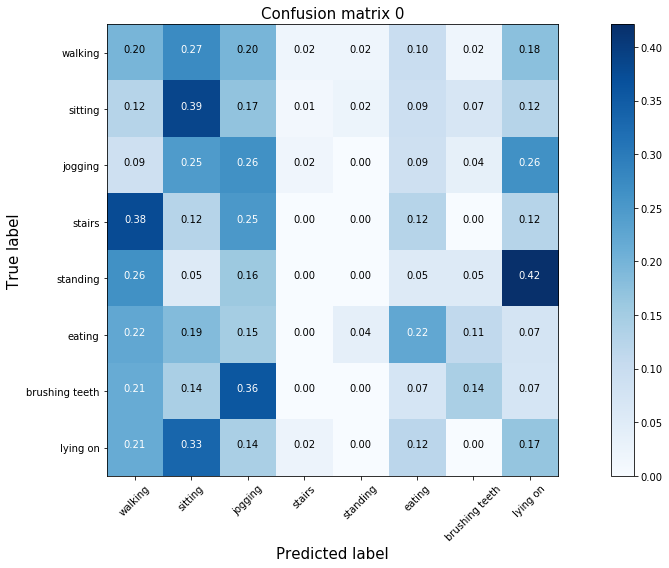

0.24183006535947713
[[10 14 10  1  1  5  1  9]
 [11 34 15  1  2  8  6 11]
 [ 5 14 15  1  0  5  2 15]
 [ 3  1  2  0  0  1  0  1]
 [ 5  1  3  0  0  1  1  8]
 [ 6  5  4  0  1  6  3  2]
 [ 3  2  5  0  0  1  2  1]
 [ 9 14  6  1  0  5  0  7]]
(3590, 6)


/home/geo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecat

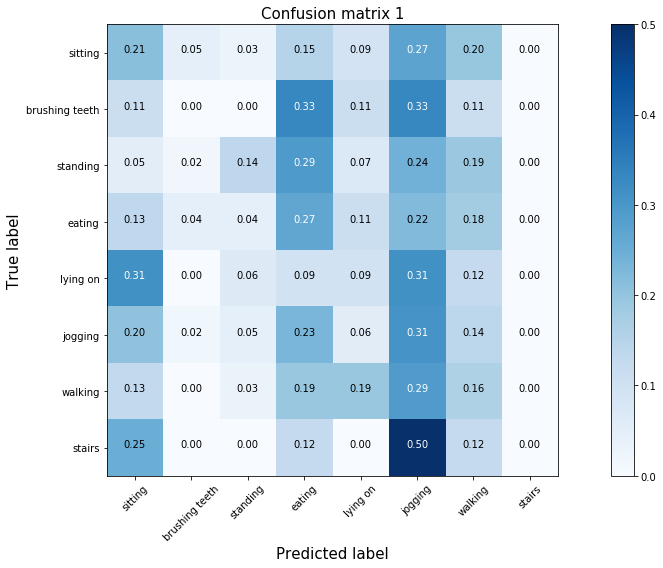

0.20491803278688525
[[14  3  2 10  6 18 13  0]
 [ 2  0  0  6  2  6  2  0]
 [ 3  1  8 17  4 14 11  0]
 [ 6  2  2 12  5 10  8  0]
 [10  0  2  3  3 10  4  0]
 [22  2  5 25  6 33 15  0]
 [ 4  0  1  6  6  9  5  0]
 [ 2  0  0  1  0  4  1  0]]
(6580, 6)


/home/geo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecat

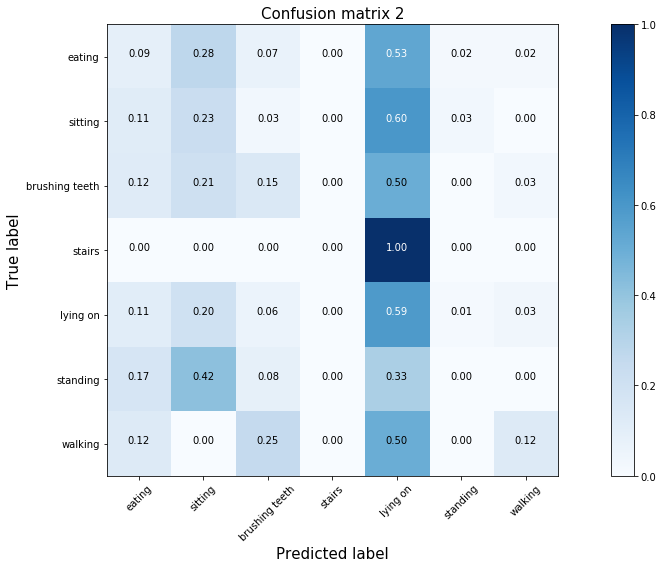

0.43832599118942733
[[  5  16   4   0  31   1   1]
 [  4   8   1   0  21   1   0]
 [  4   7   5   0  17   0   1]
 [  0   0   0   0   1   0   0]
 [ 33  61  18   0 180   4  10]
 [  2   5   1   0   4   0   0]
 [  1   0   2   0   4   0   1]]
(590, 6)


/home/geo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecat

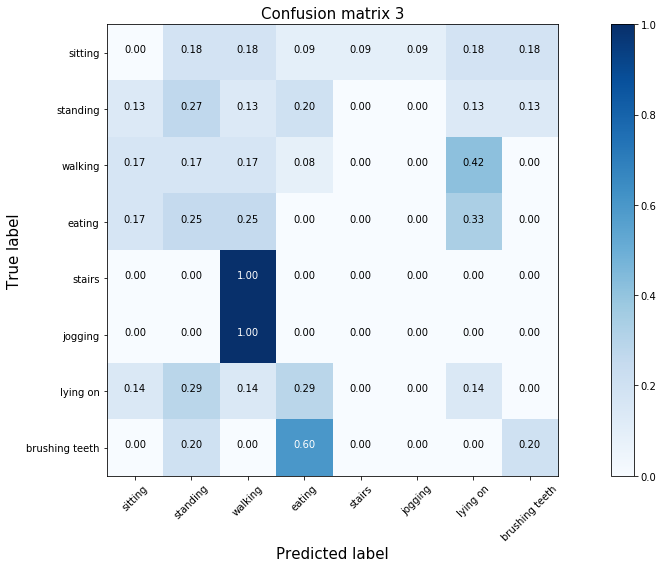

0.125
[[0 2 2 1 1 1 2 2]
 [2 4 2 3 0 0 2 2]
 [2 2 2 1 0 0 5 0]
 [2 3 3 0 0 0 4 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [1 2 1 2 0 0 1 0]
 [0 1 0 3 0 0 0 1]]
(1190, 6)


/home/geo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecat

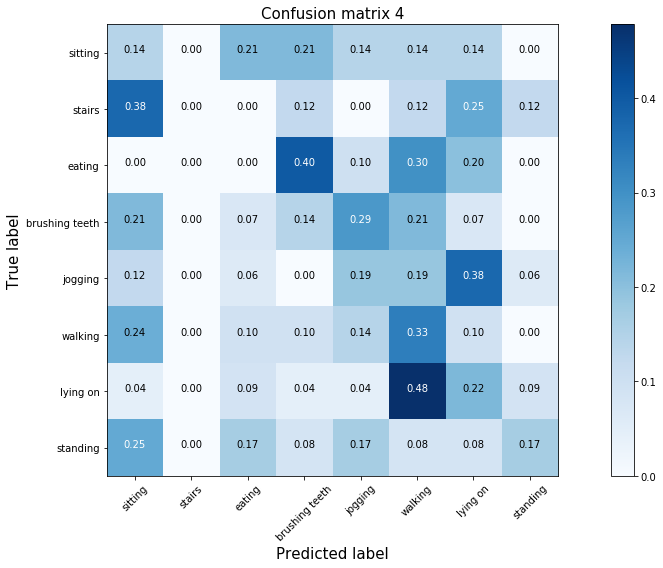

0.17796610169491525
[[ 2  0  3  3  2  2  2  0]
 [ 3  0  0  1  0  1  2  1]
 [ 0  0  0  4  1  3  2  0]
 [ 3  0  1  2  4  3  1  0]
 [ 2  0  1  0  3  3  6  1]
 [ 5  0  2  2  3  7  2  0]
 [ 1  0  2  1  1 11  5  2]
 [ 3  0  2  1  2  1  1  2]]
(2390, 6)


/home/geo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecat

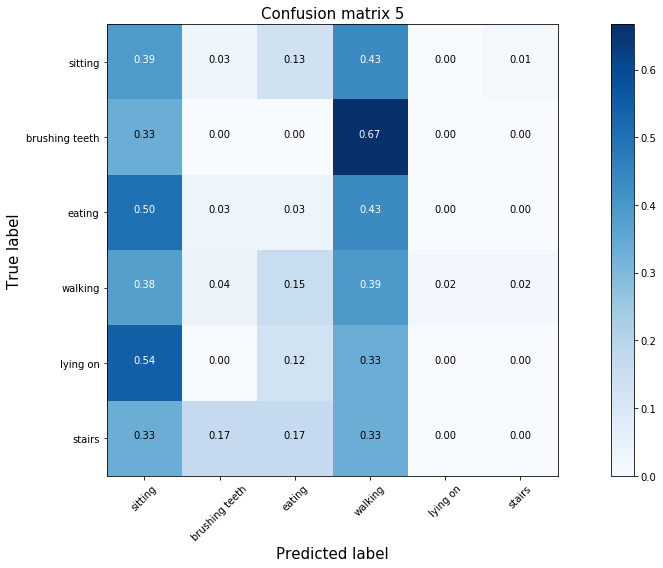

0.2518248175182482
[[27  2  9 30  0  1]
 [ 2  0  0  4  0  0]
 [15  1  1 13  0  0]
 [39  4 16 41  2  2]
 [13  0  3  8  0  0]
 [ 2  1  1  2  0  0]]


In [32]:
# This pipe is only for data transformations
transform_pipe = Pype([
    ("segment", best_estimator.named_steps["segment"]),
    ("features", best_estimator.named_steps["features"]),
    ("scaler", best_estimator.named_steps["scaler"]),
    ("pca", best_estimator.named_steps["pca"]),
], memory=None)

df_activities = pd.read_csv("./Data/HomoreDataFromVariousActivities/activities.csv")

cv = splitter.split(X, y, groups)
for fold, split in enumerate(cv):
    training_set, test_set = split
    
    # Spliting the to training and testing set
    x_train, x_test = np.asarray(X)[training_set], np.asarray(X)[test_set]
    y_train, y_test = np.asarray(y)[training_set], np.asarray(y)[test_set]
    
    visited = dict()
    labels = list()
    for yi_label in y_test:
        if yi_label not in visited:
            visited[yi_label] = True
            labels.append(yi_label)
    
    print(x_test[0].shape)
    # Transforming the test data to fit the model predictions
    _, y_test_trans = transform_pipe.fit_transform(x_test, y_test)
    
    # Fiting the model
    best_estimator.fit(x_train, y_train)
    
    # Predicting with trained model
    y_pred = best_estimator.predict(x_test)
    
    # Printing accuracy score and confusion matrix
    confusion_mat = confusion_matrix(y_test_trans, y_pred, labels=labels)
    clf_accuracy = accuracy_score(y_test_trans, y_pred)
    
    # Select the right labels and order them correcly
    labels_names = df_activities.loc[df_activities["ACTIVITY_ID"].isin(labels)]
    labels_names = labels_names.iloc[pd.Categorical(labels_names["ACTIVITY_ID"], categories = labels, ordered=True).argsort()]
    labels_names = labels_names["NAME"].to_list()
    plot_confusion_matrix(confusion_mat, labels_names, fold, normalize=True)
    
    print(clf_accuracy)
    print(confusion_mat)

# Dump and Load the model

In [21]:
best_estimator = best_estimator.fit(X, y)

/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])


In [22]:
model_path = './Model/classifier.joblib'
dump(best_estimator, model_path) 

['./Model/classifier.joblib']

In [23]:
clf = load(model_path) 

In [24]:
dummy_data = np.random.rand(350, 6)
dummy_data = [dummy_data]

In [25]:
clf.predict(dummy_data)

array([115])

In [26]:
df_accel_gyro

,index,TIMESTAMP,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,ACTIVITY_ID,USER_ID
0,0,2020-08-25 16:23:14.590,-1.230657,5.430215,7.670058,-1.084472,0.181100,-0.076701,107,0
1,1,2020-08-25 16:23:14.690,-1.743032,4.716721,8.117788,-1.465848,0.301478,-0.136357,107,0
2,2,2020-08-25 16:23:14.790,-2.229070,4.455745,8.960572,-1.877052,0.394159,-0.137423,107,0
3,3,2020-08-25 16:23:14.890,-2.496031,3.766193,9.097046,-1.774784,0.359005,-0.070309,107,0
4,4,2020-08-25 16:23:14.990,-2.711515,2.225478,9.026415,-2.076263,0.344090,-0.100138,107,0
...,...,...,...,...,...,...,...,...,...,...
460795,34795,2021-01-27 22:59:23.371,-9.205986,-2.050695,2.369134,0.025567,0.003196,-0.022370,103,5
460796,34796,2021-01-27 22:59:23.471,-9.183240,-2.038725,2.359557,0.012783,0.000000,-0.025567,103,5
460797,34797,2021-01-27 22:59:23.571,-9.261054,-2.062667,2.359557,-0.021305,-0.006392,-0.010653,103,5
460798,34798,2021-01-27 22:59:23.671,-9.233520,-1.977671,2.330826,-0.013848,0.000000,-0.010653,103,5
